# Quick start
(c) Deniz Yuret, 2019-2020

This notebook is for the impatient reader who wants to get a flavor of Julia/Knet possibly to compare it with other deep learning frameworks. In 15 lines of code and 30 seconds of GPU time we define, train, and evaluate the LeNet convolutional neural network model from scratch without any predefined layers.

In [ ]:
# Set display width, load packages
ENV["COLUMNS"]=72
using Knet, MLDatasets, IterTools, Plots

In [ ]:
# Define convolutional layer:
struct Conv; w; b; f; end
(c::Conv)(x) = c.f.(pool(conv4(c.w, x)))
Conv(w1,w2,cx,cy,f=relu) = Conv(param(w1,w2,cx,cy), param0(1,1,cy,1), f);

In [ ]:
# Define dense layer:
struct Dense; w; b; f; end
(d::Dense)(x) = d.f.(d.w * mat(x))
Dense(i::Int,o::Int,f=relu) = Dense(param(o,i), param0(o), f);

In [ ]:
# Define a chain of layers:
struct Chain; layers; Chain(args...)=new(args); end
(c::Chain)(x) = (for l in c.layers; x = l(x); end; x)
(c::Chain)(x,y) = nll(c(x),y)

In [ ]:
# Load MNIST data
xtrn,ytrn = MNIST.traindata(Float32); ytrn[ytrn.==0] .= 10
xtst,ytst = MNIST.testdata(Float32);  ytst[ytst.==0] .= 10
dtrn = minibatch(xtrn, ytrn, 100; xsize=(size(xtrn,1),size(xtrn,2),1,:))
dtst = minibatch(xtst, ytst, 100; xsize=(size(xtst,1),size(xtst,2),1,:));

In [ ]:
# Train and test LeNet (about 30 secs on a gpu to reach 99% accuracy)
LeNet = Chain(Conv(5,5,1,20), Conv(5,5,20,50), Dense(800,500), Dense(500,10,identity))
progress!(adam(LeNet, ncycle(dtrn,50)); steps=300) do prog
    w = LeNet.layers[3].w |> Array |> vec
    h = histogram(w; xlims=(-1,1), ylims=(0,length(w)*0.3), bins=-1:.05:1)
    IJulia.clear_output(true)
    IJulia.display(h)
end

In [ ]:
accuracy(LeNet, dtst)

In [ ]:
# Direcly binarize the weights
ternary(lim=0.1) = x->oftype(x, (i->i < -lim ? -1 : i > lim ? 1 : 0).(Array(x)))
binary(x) = sign.(x)
xform(m; f=ternary, l=m.layers) = Chain(
    Conv(f(l[1].w), nothing, relu),
    Conv(f(l[2].w), nothing, relu),
    Dense(f(l[3].w), nothing, relu),
    Dense(f(l[4].w), nothing, identity))

In [50]:
accuracy(xform(LeNet; f=binary), dtst)

0.9652

In [ ]:
ternarylim = [ accuracy(xform(LeNet; f=ternary(t)), dtst) for t in 0:0.01:0.2 ];

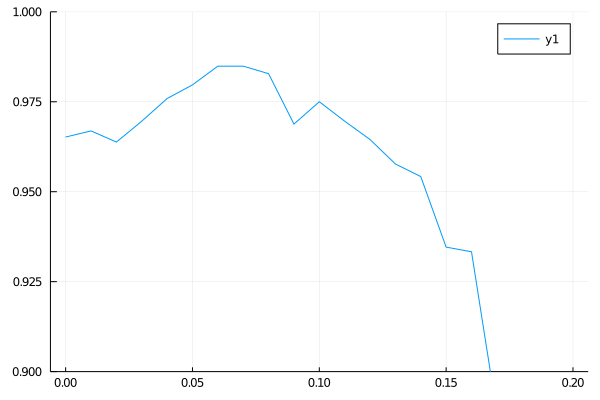

In [42]:
plot(0.0:0.01:0.2, ternarylim; ylims=(0.9,1.0))

In [46]:
using LinearAlgebra, Statistics
b = xform(LeNet; f=binary)
t = xform(LeNet; f=ternary(0.07))
for i in 1:4
    println((layer=i, 
            binary=sqrt(mean(abs2, LeNet.layers[i].w-b.layers[i].w)), 
            ternary=sqrt(mean(abs2, LeNet.layers[i].w-t.layers[i].w))))
end 

(layer = 1, binary = 0.87247926f0, ternary = 0.6565821f0)
(layer = 2, binary = 0.87546664f0, ternary = 0.6659755f0)
(layer = 3, binary = 0.8970929f0, ternary = 0.6296682f0)
(layer = 4, binary = 0.8718799f0, ternary = 0.6638652f0)


In [47]:
# Use optimal scaling factor
ternary2(lim=0.1) = x->oftype(x, mean(abs, x)*(i->i < -lim ? -1 : i > lim ? 1 : 0).(Array(x)))
binary2(x) = sign.(x) * mean(abs, x)

binary2 (generic function with 1 method)

In [48]:
# We get better approximation
b = xform(LeNet; f=binary2)
t = xform(LeNet; f=ternary2(0.07))
for i in 1:4
    println((layer=i, 
            binary=sqrt(mean(abs2, LeNet.layers[i].w-b.layers[i].w)), 
            ternary=sqrt(mean(abs2, LeNet.layers[i].w-t.layers[i].w))))
end 

(layer = 1, binary = 0.11439699f0, ternary = 0.0992725f0)
(layer = 2, binary = 0.10804898f0, ternary = 0.09385665f0)
(layer = 3, binary = 0.090609536f0, ternary = 0.07947528f0)
(layer = 4, binary = 0.11258901f0, ternary = 0.09844461f0)


In [52]:
# But it makes no difference in accuracy
accuracy(xform(LeNet; f=binary), dtst), accuracy(xform(LeNet; f=binary2), dtst)

(0.9652, 0.9652)

In [55]:
accuracy(xform(LeNet; f=ternary(0.07)), dtst), accuracy(xform(LeNet; f=ternary2(0.07)), dtst)

(0.9849, 0.9849)

In [57]:
# It does make a difference in loss
nll(xform(LeNet; f=binary), data=dtst), nll(xform(LeNet; f=binary2), data=dtst)

(232.63455f0, 0.10854888f0)

In [58]:
nll(xform(LeNet; f=ternary(0.07)), data=dtst), nll(xform(LeNet; f=ternary2(0.07)), data=dtst)

(66.68041f0, 0.06892915f0)

In [60]:
nll(LeNet, data=dtst), accuracy(LeNet, dtst)

(0.046322837f0, 0.9936)

In [61]:
# Binary Weight Network
# Binarize, run forw-back with binarized weights, do updates on float weights, rebinarize

Chain((Conv(P(KnetArray{Float32,4}(5,5,1,20)), P(KnetArray{Float32,4}(1,1,20,1)), Knet.Ops20.relu), Conv(P(KnetArray{Float32,4}(5,5,20,50)), P(KnetArray{Float32,4}(1,1,50,1)), Knet.Ops20.relu), Dense(P(KnetArray{Float32,2}(500,800)), P(KnetArray{Float32,1}(500)), Knet.Ops20.relu), Dense(P(KnetArray{Float32,2}(10,500)), P(KnetArray{Float32,1}(10)), identity)))

In [64]:
function binarize!(m2, m1)
    for (p1,p2) in zip(params(m1),params(m2))
        p2.value .= mean(abs,p1) * sign.(p1.value)
    end
end

binarize! (generic function with 1 method)

In [66]:
binarize!(LeNet2, LeNet)
accuracy(LeNet,dtst), accuracy(LeNet2,dtst)

(0.9936, 0.9652)

In [97]:
LR = 0.1
EPOCHS = 50
LeNet1 = Chain(Conv(5,5,1,20), Conv(5,5,20,50), Dense(800,500), Dense(500,10,identity))
LeNet2 = Chain(Conv(5,5,1,20), Conv(5,5,20,50), Dense(800,500), Dense(500,10,identity))
println((accuracy(LeNet1,dtst), accuracy(LeNet2,dtst)))
for (x,y) in progress(p->(accuracy(LeNet1,dtst),accuracy(LeNet2,dtst)), ncycle(dtrn,EPOCHS))
    binarize!(LeNet2,LeNet1)
    loss = @diff LeNet2(x,y)
    for (p1,p2) in zip(params(LeNet1),params(LeNet2))
        g = grad(loss,p2)
        if g !== nothing
            p1 .-= LR * g
        end
    end
end
println((accuracy(LeNet1,dtst), accuracy(LeNet2,dtst)))

(0.0921, 0.1363)


┣████████████████████┫ [100.00%, 30000/30000, 01:15/01:15, 400.11i/s] (0.8666, 0.9912)


(0.8666, 0.9912)
